In [2]:
# Basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

## Getting Started
* Download the oct_2024.snappy.parquet and data_dict.csv files from the provided link
* data_dict.csv contains a description of every column in oct_2024.snappy.parquet
* oct_2024.snappy.parquet is a parquet file, which is a common file type, with numerous advantages over csv 
    * Compression
    * Schema preservation
    * Columnar format, you can read only the columns you need, very handy when you are dealing with very wide tables, or columns containing lots of data, such as text extracts or arrays and only want the associated metadata
    
## A Note on the Data
This dataset is constructed from multiple internal tables at Auto Trader with minimal cleaning, and so is representative of real data you would find out in the wild. This does mean that there are plenty of nulls and some oddities, for example there is one entry that has taken >4 years to sell. 

Good feature cleaning and engineering will be critical in achieving a good result. Some features have extremely high cardinality (e.g. derivative), you may want to find ways of reducing this, or finding alternative ways to represent the data.

Sometimes the data that is easy to pull is not the data that you want for the problem, think carefully about the features you have been provided and whether a production grade would would have access to them at inference time. Also consider any biases present in the dataset. This data is looking at a set of subset of sales that occured in October 2024, and is mainly last-seen properties of the advert.

In [7]:
# Data paths
dict_path = "data_dict.csv"
data_path = "oct_2024.snappy.parquet"

# Read in data
data_dict_df = pd.read_csv(dict_path)
raw_data_df = pd.read_parquet(data_path)

In [8]:
pd.set_option('display.max_colwidth', None) # Prevents truncation of long text columns
data_dict_df

,Field,Description
0,stock_item_id,Unique ID of the advert e.g. 8a42801e86dad35a0186dd181f956cb5
1,last_date_seen,The date the vehicle was last seen advertised on Auto Trader e.g. 2023-01-31
2,first_date_seen,The first date the vehicle was listed on Auto Trader
3,days_to_sell,The difference in days between first_date_seen and last_date_seen
4,first_retailer_asking_price,The price the advert had when first created. This may have been a temp holding price before it went live.
5,last_retailer_asking_price,The last seen price
6,can_home_deliver,This advert is able to be delivered to the buyers home
7,reviews_per_100_advertised_stock_last_12_months,"How many reviews the seller has recieved in the last 12 months per 100 stock advertised, i.e. 200 stock advertised over the whole year, 150 reviews 150/2= 75"
8,segment,Whether the seller is a Franchise or Independent retailer
9,seats,Number of seats in the vehicle


In [9]:
raw_data_df.head(4)

,stock_item_id,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,...,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,first_image_label,advert_quality,postcode_area
0,33e3749b79a2847010ec1ad4716745393a2fd6b7d9db8d0563363085e1435502,2024-10-07,2022-10-12,726,24495,18995,False,0.3,Independent,5.0,...,2016-09-09,None,False,GOOD,18716.0,73842.0,11,FRONT_RIGHT,72,BT
1,cbf6f80e01e939aa017a9641d02f5cc24f78c3e69d9a742fe53edf30116053e6,2024-10-25,2023-05-13,531,16990,12990,False,0.9,Franchise,5.0,...,2021-01-14,£750 deposit contribution*,True,GOOD,13110.0,22740.0,12,FRONT_RIGHT,55,HA
2,c49040c0388b7533accbf7d4db144efbe7b2a251256b3bb3bdab3253f0e23abe,2024-10-05,2023-07-31,432,14481,11913,False,9.1,Independent,5.0,...,2016-12-17,SAT NAV • REAR CAMERA,False,GOOD,11873.0,55729.0,38,FRONT_RIGHT,41,BS
3,eacc77fecac6a43b328d0cbb16c192baa0654284a37b7d5219d81ff255124f5b,2024-10-21,2023-09-18,399,61000,36500,False,2.9,Franchise,5.0,...,2023-05-15,8.9 PERCENT APR AVAILABLE,False,GOOD,36809.0,10689.0,49,FRONT_RIGHT,71,PR


In [12]:
raw_data_df.shape

(155676, 43)

In [13]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155676 entries, 0 to 155675
Data columns (total 43 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   stock_item_id                                    155676 non-null  object 
 1   last_date_seen                                   155676 non-null  object 
 2   first_date_seen                                  155676 non-null  object 
 3   days_to_sell                                     155676 non-null  int32  
 4   first_retailer_asking_price                      155676 non-null  int64  
 5   last_retailer_asking_price                       155676 non-null  int64  
 6   can_home_deliver                                 155676 non-null  bool   
 7   reviews_per_100_advertised_stock_last_12_months  141413 non-null  float64
 8   segment                                          155577 non-null  object 
 9   seats          

## Select Column Types

### Select Numeric DataFrame

In [16]:
numeric_df = raw_data_df.select_dtypes(include=[np.number])
numeric_df

,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,reviews_per_100_advertised_stock_last_12_months,seats,doors,co2_emission_gpkm,top_speed_mph,battery_range_miles,boot_space_seats_up_litres,odometer_reading_miles,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality
0,726,24495,18995,0.3,5.0,5.0,129.0,138.0,NaN,550.0,78000,18716.0,73842.0,11,72
1,531,16990,12990,0.9,5.0,5.0,129.0,115.0,NaN,330.0,16908,13110.0,22740.0,12,55
2,432,14481,11913,9.1,5.0,5.0,179.0,113.0,NaN,589.0,76264,11873.0,55729.0,38,41
3,399,61000,36500,2.9,5.0,5.0,0.0,124.0,281.0,569.0,18500,36809.0,10689.0,49,71
4,383,129995,109995,11.1,5.0,5.0,299.0,137.0,NaN,0.0,74000,109023.0,34559.0,46,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155671,2,4250,4250,9.1,5.0,5.0,108.0,118.0,NaN,348.0,51812,3983.0,93028.0,57,67
155672,2,8749,8749,10.3,5.0,5.0,108.0,112.0,NaN,380.0,51071,8677.0,50051.0,18,75
155673,3,6980,6980,NaN,5.0,5.0,124.0,118.0,NaN,292.0,37432,8048.0,72790.0,25,71
155674,2,14899,14899,0.7,5.0,5.0,166.0,113.0,NaN,491.0,40348,14941.0,24437.0,6,24


In [17]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155676 entries, 0 to 155675
Data columns (total 15 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   days_to_sell                                     155676 non-null  int32  
 1   first_retailer_asking_price                      155676 non-null  int64  
 2   last_retailer_asking_price                       155676 non-null  int64  
 3   reviews_per_100_advertised_stock_last_12_months  141413 non-null  float64
 4   seats                                            155589 non-null  float64
 5   doors                                            155667 non-null  float64
 6   co2_emission_gpkm                                155592 non-null  float64
 7   top_speed_mph                                    155295 non-null  float64
 8   battery_range_miles                              10754 non-null   float64
 9   boot_space_seat

### Select Categorical DataFrame

In [19]:
categorical_df = raw_data_df.select_dtypes(include=["object", "bool"])
categorical_df

,stock_item_id,last_date_seen,first_date_seen,can_home_deliver,segment,zero_to_sixty_mph_seconds,engine_power_bhp,fuel_economy_wltp_combined_mpg,battery_usable_capacity_kwh,length_mm,...,fuel_type,transmission_type,drivetrain,colour,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,first_image_label,postcode_area
0,33e3749b79a2847010ec1ad4716745393a2fd6b7d9db8d0563363085e1435502,2024-10-07,2022-10-12,False,Independent,7.6,201.0,56.5,None,4656.0,...,Diesel,Automatic,Four Wheel Drive,Red,2016-09-09,None,False,GOOD,FRONT_RIGHT,BT
1,cbf6f80e01e939aa017a9641d02f5cc24f78c3e69d9a742fe53edf30116053e6,2024-10-25,2023-05-13,False,Franchise,10.7,94.0,49.6,None,3997.0,...,Petrol,Automatic,Front Wheel Drive,White,2021-01-14,£750 deposit contribution*,True,GOOD,FRONT_RIGHT,HA
2,c49040c0388b7533accbf7d4db144efbe7b2a251256b3bb3bdab3253f0e23abe,2024-10-05,2023-07-31,False,Independent,None,153.0,36.7,None,4605.0,...,Petrol,Automatic,Four Wheel Drive,Silver,2016-12-17,SAT NAV • REAR CAMERA,False,GOOD,FRONT_RIGHT,BS
3,eacc77fecac6a43b328d0cbb16c192baa0654284a37b7d5219d81ff255124f5b,2024-10-21,2023-09-18,False,Franchise,None,335.0,None,89.0,4915.0,...,Electric,Automatic,Four Wheel Drive,Grey,2023-05-15,8.9 PERCENT APR AVAILABLE,False,GOOD,FRONT_RIGHT,PR
4,3618f09687bd940abafde2cbeab7181df5e1055d5c000dffb97e113746f9ae41,2024-10-25,2023-10-08,True,Independent,4.5,577.0,21.4,None,4873.0,...,Petrol,Automatic,Four Wheel Drive,White,2019-03-24,*6 MONTHS FREE RAC WARRANTY*,False,NOANALYSIS,FRONT_LEFT,OL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155671,0bc7ebe270e841d4769092bb1cc68ff081e5a6025a99066fef7cf7eb0dabb522,2024-10-28,2024-10-26,False,Independent,12.5,113.0,68.9,None,4276.0,...,Diesel,Manual,Front Wheel Drive,White,2013-09-27,1 OWNER + FULL SERVICE HISTORY,False,FAIR,FRONT_RIGHT,YO
155672,2daa6779a00e6f9a09823c81440c630f8dab8123c8931ff34121e075f18a31ef,2024-10-30,2024-10-28,False,Independent,None,84.0,58.9,None,4258.0,...,Petrol,Manual,Front Wheel Drive,White,2017-06-22,Low Owners - FSH,False,GOOD,FRONT_RIGHT,ML
155673,0131d125eda33fb9ba03665fad1baa1187ca2b12d91657effb5abe8676e589f9,2024-10-31,2024-10-28,False,Franchise,None,104.0,53.3,None,4061.0,...,Petrol,Automatic,Front Wheel Drive,Blue,2014-01-13,None,True,LOW,FRONT_RIGHT,BS
155674,556feab4b5c1ecfbf6532ddd6b2dd4ce7e6111fc39b27e0ef5ac5f61d32677bd,2024-10-31,2024-10-29,False,Franchise,11.1,130.0,38.7,None,4485.0,...,Petrol,Manual,Front Wheel Drive,Silver,2021-07-15,Pics coming soon,False,GOOD,PROMOTIONAL_MATERIAL,BT


In [21]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155676 entries, 0 to 155675
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   stock_item_id                   155676 non-null  object
 1   last_date_seen                  155676 non-null  object
 2   first_date_seen                 155676 non-null  object
 3   can_home_deliver                155676 non-null  bool  
 4   segment                         155577 non-null  object
 5   zero_to_sixty_mph_seconds       59770 non-null   object
 6   engine_power_bhp                155375 non-null  object
 7   fuel_economy_wltp_combined_mpg  149902 non-null  object
 8   battery_usable_capacity_kwh     10728 non-null   object
 9   length_mm                       155499 non-null  object
 10  insurance_group                 101178 non-null  object
 11  plate                           155668 non-null  object
 12  make                          

### Sanity check Numeric and Categorical DataFrame add up to whole

In [27]:
len(raw_data_df.columns) == (len(numeric_df.columns) + len(categorical_df.columns))

True

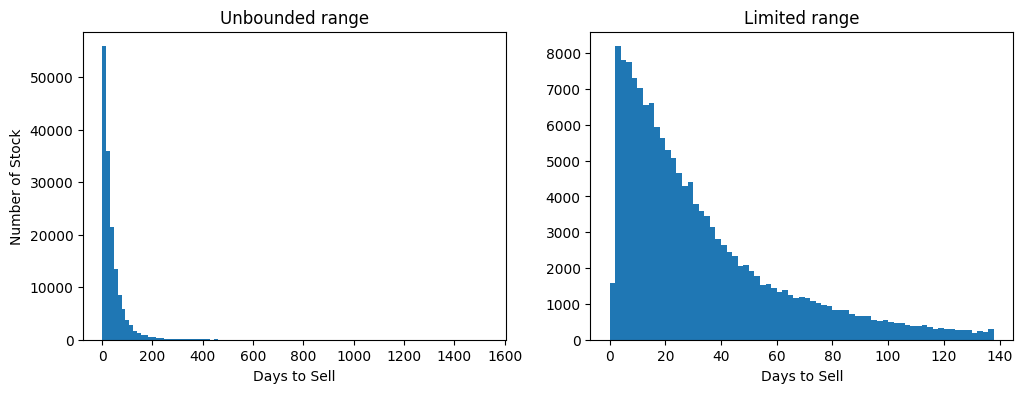

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(raw_data_df['days_to_sell'], bins=100)
ax[1].hist(raw_data_df['days_to_sell'], bins=np.arange(0,140,2))

ax[0].set_xlabel('Days to Sell')
ax[1].set_xlabel('Days to Sell')

ax[0].set_ylabel('Number of Stock')
ax[0].set_title('Unbounded range')
ax[1].set_title('Limited range')
plt.show()
plt.close()

## Exploring missing values

In [14]:
# # Handles Nulls from New cars in the data
# raw_data_df['first_registration_date'] = raw_data_df['first_registration_date'].fillna(raw_data_df['last_date_seen'])
# # Some registration dates are extremely old (i.e. 1000s of years) and can cause issues 
# clean_dates_df = raw_data_df.loc[raw_data_df['first_registration_date']>dt.date(1950,1,1)].copy()

# clean_dates_df['days_old'] = (clean_dates_df['last_date_seen'] - clean_dates_df['first_registration_date']).dt.days
# clean_dates_df['days_old']